## Part 4: Import Libraries & Cleaned Dataset

In [197]:
#Import Neccessary Libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings #Ignore all warnings
warnings.filterwarnings("ignore")

from scipy import stats

from sklearn.preprocessing import LabelEncoder

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.api as sms


from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from sklearn.feature_selection import RFE

In [198]:
#Load in Cleaned Dataset
#Display first 5 rows

data = pd.read_csv('kc_house_data_cleaned.csv')
df = pd.DataFrame(data)
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode
0,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0.0,3,7,1180,0.0,1955,0.0,98178
1,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,2170,400.0,1951,1991.0,98125
2,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,3,6,770,0.0,1933,0.0,98028
3,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,1050,910.0,1965,0.0,98136
4,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,1680,0.0,1987,0.0,98074


## Part 5: Exploratory Data Analysis and Regression Modeling (Trials 5-9)

In this section, new columns were created to take a deep dive into the deciding factors that drive housing costs like the age of the house and size of the yard. Trends in when (month & year) homewoners sold their homes were also sought after. These new columns were added to the previously cleaned dataframe and was used to build the subsequent models below. 

**Model 7** produced the highest coefficient of determination of 0.652. Model 7 is validated in this section as well.


In [199]:
#Convert 'Month' and 'Year' to datetime objects and create new columns for each. 
#This information will provide insights to the best worst times to buy and sell homes
df['month_sold'] = pd.DatetimeIndex(df['date']).month
df['yr_sold'] = pd.DatetimeIndex(df['date']).year

#Determine how old the homes are and and the size of the yard of the home
#create new columns for each. With this new column, the sqft_lot', 
#'sqft_above', and 'sqft_basement', dropped from the Dataframe.
df['age'] = df['yr_sold'] - df['yr_built']
df['%yard'] = (df['sqft_lot'] - (df['sqft_above'] / df['floors'])) / df['sqft_lot']

In [200]:
#Assumptions: '0.0' means that the house does not have a basement and has not been renovated. 
#Assign columns with "years" to 1.

df.loc[(df['sqft_basement'] > 0), 'sqft_basement'] = 1
df.loc[df['yr_renovated'] > 0.0 , 'is_renovated'] = 1.0

#Fill NaN values with '0' due to uncertainty.  
df['is_renovated'] = df['is_renovated'].fillna(0.0)
df = df.drop(['date', 'yr_renovated'], axis=1)

In [201]:
#Change columns name "%yard" to "perc" to prevent the '%' 
#symbol from cuasing erros in the model. Print columns.

print(formula)
df['perc'] = df['%yard']
df = df.drop(['%yard'], axis=1)
df.columns

price~bedrooms+bathrooms+sqft_living+sqft_lot+floors+waterfront+condition+grade+sqft_above+sqft_basement+yr_built+zipcode+month_sold+yr_sold+age+is_renovated+perc


Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'condition', 'grade', 'sqft_above', 'sqft_basement',
       'yr_built', 'zipcode', 'month_sold', 'yr_sold', 'age', 'is_renovated',
       'perc'],
      dtype='object')

### Model Building: Trial 6 with Cleaned DataFrame

       bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0             3       1.00         1180      5650     1.0         0.0   
1             3       2.25         2570      7242     2.0         0.0   
2             2       1.00          770     10000     1.0         0.0   
3             4       3.00         1960      5000     1.0         0.0   
4             3       2.00         1680      8080     1.0         0.0   
...         ...        ...          ...       ...     ...         ...   
21591         3       2.50         1530      1131     3.0         0.0   
21592         4       2.50         2310      5813     2.0         0.0   
21593         2       0.75         1020      1350     2.0         0.0   
21594         3       2.50         1600      2388     2.0         0.0   
21595         2       0.75         1020      1076     2.0         0.0   

       condition  grade  sqft_above  sqft_basement  yr_built  zipcode  \
0              3      7        1180            0.0

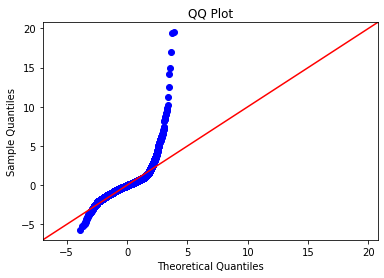

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     2525.
Date:                Fri, 05 Jun 2020   Prob (F-statistic):               0.00
Time:                        08:42:19   Log-Likelihood:            -2.9598e+05
No. Observations:               21596   AIC:                         5.920e+05
Df Residuals:                   21579   BIC:                         5.921e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -5.212e+07   1.07e+07     -4.855      0.000   -7.32e+07   -3.11e+07
bedrooms      -4.471e+04   2126.056    -21.031      0.000   -4.89e+04   -4.05e+04
bathrooms      4.264e+04   3558.326     11.984      0.000    3.57e+04    4.96e+04
sqft_living     193.3523      6.378     30.315      0.000     180.851     205.854
sqft_lot         -0.0570      0.039     -1.473      0.141      -0.133       0.019
floors         1.356e+04   3908.935      3.469      0.001    5897.977    2.12e+04
waterfront     7.637e+05   1.83e+04     41.748      0.000    7.28e+05       8e+05
condition      2.179e+04   2529.352      8.616      0.000    1.68e+04    2.68e+04
grade          1.286e+05   2176.280     59.113      0.000    1.24e+05    1.33e+05
sqft_above       -8.4596      6.962     -1.215      0.224     -22.106       5.187
sqft_basement  -324.7883   5470.977     -0.059      0.953    -1.1e+04    1.04e+04
yr_built       8377.4031   1694.322      4.944      0.000    5056.407    1.17e+04
zipcode         -71.6502     31.524     -2.273      0.023    -133.439      -9.861
month_sold      899.7486    761.352      1.182      0.237    -592.557    2392.054
yr_sold        2.057e+04   3387.172      6.073      0.000    1.39e+04    2.72e+04
age            1.219e+04   1693.659      7.199      0.000    8873.317    1.55e+04
is_renovated   2.998e+04   8539.973      3.511      0.000    1.32e+04    4.67e+04
perc          -2.528e+05   1.67e+04    -15.176      0.000   -2.86e+05    -2.2e+05
==============================================================================
Omnibus:                    15921.661   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1034091.553
Skew:                           2.951   Prob(JB):                         0.00
Kurtosis:                      36.382   Cond. No.                     3.90e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.41e-23. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [202]:
#Returns model summary, residuals, and Q-Q Plots

def fullRegressionAnalysis(b, df, a='price'):
    '''a: str Dependent variable column name
        b: List of str Independent variable columns
        df: dataframe Dataframe to analyze
        
        First line of regression analysis between the dependent variable and a single independent variable in a dataFrame
    
        Returns
        R-squared value
        Intercept
        Slope
        P-Value
        JB Score & Probability of JB
        Statistical signfigance
        Rejection of normal distribution of errors
        Scatter plot with Line of Best Fit
        Regression plots for column2 vs. model
        QQ plot
        Model Summary Statistics'''

    
    b = df.drop(a, axis=1)
    pred_sum = '+'.join(b.columns)
    f = a+'~'+pred_sum
    model = ols(formula=f, data=df).fit()
    print (b, 'vs.', a)
    print ('R-Squared:',model.rsquared)
    print ('Intercept:',model.params[0])
    print ('Slope:',model.params[1])
    print ('P-Value:',round(model.pvalues[1],4))
    print ('JB Score:',sms.jarque_bera(model.resid)[0], 'Probability:', sms.jarque_bera(model.resid)[1])
    if model.pvalues[1] <= 0.05:
        print('  *',b,'HAS a statistically significant relationship to',a)
    else:
        print('  *',b,'DOES NOT HAVE a statistically significant relationship to',a)
    if sms.jarque_bera(model.resid)[0] >= 6 and sms.jarque_bera(model.resid)[1] <= 0.05:
        print('  * We REJECT the normal distribution of the model errors')
    residuals = model.resid
    fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
    plt.title('QQ Plot')
    plt.show()    
    return model.summary()

a = 'price'
b = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'zipcode', 'month_sold',
       'yr_sold', 'age', '%yard', 'is_renovated']

fullRegressionAnalysis(a=a, b=b, df=df)

In [230]:
#Drop features who have p-values that are > 0.05

df_lowp = df.drop(['sqft_lot', 'sqft_above', 'sqft_basement', 'month_sold', 'zipcode'], axis=1)
df_lowp.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront',
       'condition', 'grade', 'yr_built', 'yr_sold', 'age', 'is_renovated',
       'perc'],
      dtype='object')

### Model Building: Trial 7 with P-Values > 0.05 Removed
#### This model produced the highest R Squared Value: 0.652

       bedrooms  bathrooms  sqft_living  floors  waterfront  condition  grade  \
0             3       1.00         1180     1.0         0.0          3      7   
1             3       2.25         2570     2.0         0.0          3      7   
2             2       1.00          770     1.0         0.0          3      6   
3             4       3.00         1960     1.0         0.0          5      7   
4             3       2.00         1680     1.0         0.0          3      8   
...         ...        ...          ...     ...         ...        ...    ...   
21591         3       2.50         1530     3.0         0.0          3      8   
21592         4       2.50         2310     2.0         0.0          3      8   
21593         2       0.75         1020     2.0         0.0          3      7   
21594         3       2.50         1600     2.0         0.0          3      8   
21595         2       0.75         1020     2.0         0.0          3      7   

       yr_built  yr_sold  a

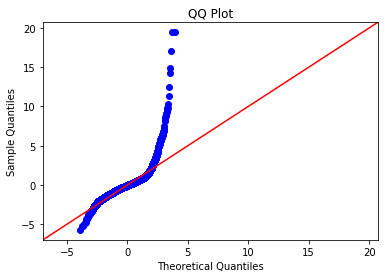

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     3671.
Date:                Fri, 05 Jun 2020   Prob (F-statistic):               0.00
Time:                        08:46:40   Log-Likelihood:            -2.9599e+05
No. Observations:               21596   AIC:                         5.920e+05
Df Residuals:                   21584   BIC:                         5.921e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -4.962e+07   6.37e+06     -7.786      0.000   -6.21e+07   -3.71e+07
bedrooms     -4.414e+04   2112.477    -20.893      0.000   -4.83e+04      -4e+04
bathrooms     4.352e+04   3488.897     12.473      0.000    3.67e+04    5.04e+04
sqft_living    187.1466      3.315     56.458      0.000     180.649     193.644
floors        9857.0673   3507.542      2.810      0.005    2982.025    1.67e+04
waterfront    7.641e+05   1.83e+04     41.848      0.000    7.28e+05       8e+05
condition     2.276e+04   2499.342      9.107      0.000    1.79e+04    2.77e+04
grade          1.28e+05   2142.705     59.756      0.000    1.24e+05    1.32e+05
yr_built      6816.3872   1055.221      6.460      0.000    4748.076    8884.699
yr_sold       1.741e+04   2108.883      8.256      0.000    1.33e+04    2.15e+04
age           1.059e+04   1054.798     10.043      0.000    8526.283    1.27e+04
is_renovated  3.058e+04   8531.117      3.584      0.000    1.39e+04    4.73e+04
perc         -2.574e+05   1.53e+04    -16.863      0.000   -2.87e+05   -2.28e+05
==============================================================================
Omnibus:                    15935.618   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1034259.937
Skew:                           2.956   Prob(JB):                         0.00
Kurtosis:                      36.383   Cond. No.                     1.45e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.3e-23. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [231]:
#Run fullRegressionAnalysis function with features whose p_values are less than 0.05

a = 'price'
b = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront',
       'condition', 'grade', 'yr_built', 'yr_sold', 'age', 'is_renovated',
       'perc']

fullRegressionAnalysis(a=a, b=b, df=df_lowp)

In [205]:
#Print the intercept and coefficients of our linear regression model 
print(linreg.intercept_)
print(linreg.coef_)

[-44011.54263376]
[[280.86880525]]


In [206]:
#Check independent vaiable correlations amongst each other and return the correlations > 0.70
corrr = df.corr().abs() #Take the absolute value of all correlations
m = ~(corrr.mask(np.eye(len(corrr), dtype=bool)).abs() > 0.70).any() #Replace all values greater than 0.70 with nothing
raw = corrr.loc[m, m] #Return the rows and columns of the new dataframe of correlations
raw

,bedrooms,sqft_lot,floors,waterfront,condition,sqft_basement,zipcode,is_renovated,perc
bedrooms,1.000000,0.033602,0.183707,0.002054,0.023440,0.160391,0.158588,0.018354,0.073275
sqft_lot,0.033602,1.000000,0.004824,0.021458,0.008806,0.034877,0.129582,0.005089,0.337168
floors,0.183707,0.004824,1.000000,0.020794,0.264013,0.252426,0.059522,0.003705,0.261208
waterfront,0.002054,0.021458,0.020794,1.000000,0.016659,0.039227,0.028925,0.074267,0.058693
condition,0.023440,0.008806,0.264013,0.016659,1.000000,0.130422,0.002835,0.055369,0.111868
sqft_basement,0.160391,0.034877,0.252426,0.039227,0.130422,1.000000,0.159578,0.044613,0.060422
zipcode,0.158588,0.129582,0.059522,0.028925,0.002835,0.159578,1.000000,0.062383,0.199126
is_renovated,0.018354,0.005089,0.003705,0.074267,0.055369,0.044613,0.062383,1.000000,0.013100
perc,0.073275,0.337168,0.261208,0.058693,0.111868,0.060422,0.199126,0.013100,1.000000


### Model Building: Trial 8 with Highly Correlated Features Removed

In [208]:
#Create a dataframe of features displaying the 
#least amount of multicollinearity called noncolin_df.

non_colin = ['price', 'bedrooms', 'sqft_lot', 'floors',
       'waterfront', 'condition', 'sqft_basement',
       'yr_built', 'zipcode','is_renovated',
       'perc']
noncolin_df = df[non_colin]

       bedrooms  sqft_lot  floors  waterfront  condition  sqft_basement  \
0             3      5650     1.0         0.0          3            0.0   
1             3      7242     2.0         0.0          3            1.0   
2             2     10000     1.0         0.0          3            0.0   
3             4      5000     1.0         0.0          5            1.0   
4             3      8080     1.0         0.0          3            0.0   
...         ...       ...     ...         ...        ...            ...   
21591         3      1131     3.0         0.0          3            0.0   
21592         4      5813     2.0         0.0          3            0.0   
21593         2      1350     2.0         0.0          3            0.0   
21594         3      2388     2.0         0.0          3            0.0   
21595         2      1076     2.0         0.0          3            0.0   

       yr_built  zipcode  is_renovated      perc  
0          1955    98178           0.0  0.791150

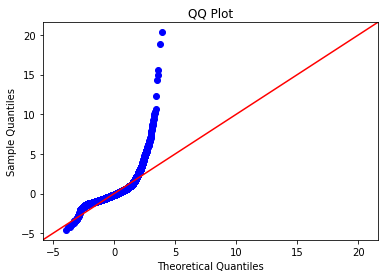

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                     792.5
Date:                Fri, 05 Jun 2020   Prob (F-statistic):               0.00
Time:                        08:42:21   Log-Likelihood:            -3.0400e+05
No. Observations:               21596   AIC:                         6.080e+05
Df Residuals:                   21585   BIC:                         6.081e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      4.531e+07   4.54e+06      9.981      0.000    3.64e+07    5.42e+07
bedrooms       9.203e+04   2543.340     36.183      0.000     8.7e+04     9.7e+04
sqft_lot          0.7577      0.055     13.704      0.000       0.649       0.866
floors          2.13e+05   4990.012     42.683      0.000    2.03e+05    2.23e+05
waterfront     1.087e+06   2.63e+04     41.332      0.000    1.04e+06    1.14e+06
condition      3.229e+04   3633.020      8.888      0.000    2.52e+04    3.94e+04
sqft_basement  1.499e+05   4802.488     31.220      0.000    1.41e+05    1.59e+05
yr_built      -1119.9813     98.125    -11.414      0.000   -1312.313    -927.649
zipcode        -441.9997     45.456     -9.724      0.000    -531.096    -352.903
is_renovated   1.492e+05   1.22e+04     12.199      0.000    1.25e+05    1.73e+05
perc          -3.565e+04   2.38e+04     -1.498      0.134   -8.23e+04     1.1e+04
==============================================================================
Omnibus:                    17878.360   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1110809.370
Skew:                           3.585   Prob(JB):                         0.00
Kurtosis:                      37.396   Cond. No.                     2.11e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.11e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [209]:
#Build a model using the dataframe noncolin_df
a = 'price'
b = ['price', 'bedrooms', 'sqft_lot', 'floors',
       'waterfront', 'condition', 'sqft_basement',
       'yr_built', 'zipcode','is_renovated',
       'perc']

fullRegressionAnalysis(a=a, b=b, df=noncolin_df)

### Perform a Test-Train Split Using the Trial 7 Model (Model Seven)

In [210]:
y = df_lowp[['price']] #Assign the dependent variable, price, to 'y'
X =df_lowp.drop(['price'], axis=1) #Assign the independent variables to 'x'

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

print(len(X_train), len(X_test), len(y_train), len(y_test))

14469 7127 14469 7127


### Model Seven Validation

In [211]:
def kfolds(df, k):
    """ Splits a dataframe into k evenly sized pieces. If the full 
        dataset is not divisible by k, kfolds makes
        the first few folds one (+1) larger then later folds.
    """
    num_observations = len(df) #
    fold_size = num_observations//k
    leftovers = num_observations%k
    folds = []
    start_obs = 0 # this counter indicates the index value where each fold should start
    for fold_n in range(1,k+1):
        if fold_n <= leftovers:
            #Fold Size will be 1 larger to account for leftovers
            fold =  data.iloc[start_obs : start_obs+fold_size+1] #index dataframe values from the start of the fold partition to the end
            folds.append(fold) #add this list of values to the folds list
            start_obs +=  fold_size + 1
        else:
            fold =  data.iloc[start_obs : start_obs+fold_size] 
            folds.append(fold)
            start_obs +=  fold_size
            
    return folds 

In [212]:
def get_errors(folds, k):
    """
    Performs linear regression on each fold and 
    calculates the training and test error
    """
    test_errs = []
    train_errs = []


    for n in range(k):
        # Split in train and test for the fold
        train = pd.concat([fold for i, fold in enumerate(df_lowp_fold) if i!=n])
        test = df_lowp_fold[n]
        # Fit a linear regression model
        linreg.fit(X_train, y_train)
        #Evaluate Train and Test Errors
        y_hat_train = linreg.predict(X_train)
        y_hat_test = linreg.predict(X_test)
        train_residuals = y_hat_train - y_train
        test_residuals = y_hat_test - y_test
        train_errs.append(np.mean(train_residuals.astype(float)**2))
        test_errs.append(np.mean(test_residuals.astype(float)**2))
    print(train_errs)
    print(test_errs)
    


In [213]:
# 5 Folds; k=5
df_lowp_fold = kfolds(df=df_lowp, k=5)
five_fold = get_errors(folds=df_lowp_fold, k=5)

[price    4.704668e+10
dtype: float64, price    4.704668e+10
dtype: float64, price    4.704668e+10
dtype: float64, price    4.704668e+10
dtype: float64, price    4.704668e+10
dtype: float64]
[price    4.700391e+10
dtype: float64, price    4.700391e+10
dtype: float64, price    4.700391e+10
dtype: float64, price    4.700391e+10
dtype: float64, price    4.700391e+10
dtype: float64]


In [214]:
# 10 Folds; k=10

df_lowp_fold = kfolds(df=df_lowp, k=10)
ten_fold = get_errors(folds=df_lowp_fold, k=10)

[price    4.704668e+10
dtype: float64, price    4.704668e+10
dtype: float64, price    4.704668e+10
dtype: float64, price    4.704668e+10
dtype: float64, price    4.704668e+10
dtype: float64, price    4.704668e+10
dtype: float64, price    4.704668e+10
dtype: float64, price    4.704668e+10
dtype: float64, price    4.704668e+10
dtype: float64, price    4.704668e+10
dtype: float64]
[price    4.700391e+10
dtype: float64, price    4.700391e+10
dtype: float64, price    4.700391e+10
dtype: float64, price    4.700391e+10
dtype: float64, price    4.700391e+10
dtype: float64, price    4.700391e+10
dtype: float64, price    4.700391e+10
dtype: float64, price    4.700391e+10
dtype: float64, price    4.700391e+10
dtype: float64, price    4.700391e+10
dtype: float64]


In [215]:
# 20 Folds; k=20
df_lowp_fold = kfolds(df=df_lowp, k=20)
ten_fold = get_errors(folds=df_lowp_fold, k=20)

[price    4.704668e+10
dtype: float64, price    4.704668e+10
dtype: float64, price    4.704668e+10
dtype: float64, price    4.704668e+10
dtype: float64, price    4.704668e+10
dtype: float64, price    4.704668e+10
dtype: float64, price    4.704668e+10
dtype: float64, price    4.704668e+10
dtype: float64, price    4.704668e+10
dtype: float64, price    4.704668e+10
dtype: float64, price    4.704668e+10
dtype: float64, price    4.704668e+10
dtype: float64, price    4.704668e+10
dtype: float64, price    4.704668e+10
dtype: float64, price    4.704668e+10
dtype: float64, price    4.704668e+10
dtype: float64, price    4.704668e+10
dtype: float64, price    4.704668e+10
dtype: float64, price    4.704668e+10
dtype: float64, price    4.704668e+10
dtype: float64]
[price    4.700391e+10
dtype: float64, price    4.700391e+10
dtype: float64, price    4.700391e+10
dtype: float64, price    4.700391e+10
dtype: float64, price    4.700391e+10
dtype: float64, price    4.700391e+10
dtype: float64, price    4

In [216]:
#Perform Cross Validation
# Average the individual results from the 
# linear models to get a Cross-Validation MSE (Mean Squared Error)

from sklearn.model_selection import cross_val_score

cv_5_results  = np.mean(cross_val_score(linreg, X, y, cv=5,  scoring='neg_mean_squared_error'))
cv_10_results = np.mean(cross_val_score(linreg, X, y, cv=10, scoring='neg_mean_squared_error'))
cv_20_results = np.mean(cross_val_score(linreg, X, y, cv=20, scoring='neg_mean_squared_error'))

print('5-Fold Cross-Validation: ' ,cv_5_results)
print('10-Fold Cross-Validation: ' ,cv_10_results)
print('20-Fold Cross-Validation: ' ,cv_10_results)

5-Fold Cross-Validation:  -47355049875.49669
10-Fold Cross-Validation:  -47275421620.260445
20-Fold Cross-Validation:  -47275421620.260445


### Plot the Lines of Best Fit for the Top 3 Features: 'grade', 'sqft_living', and 'bathrooms'

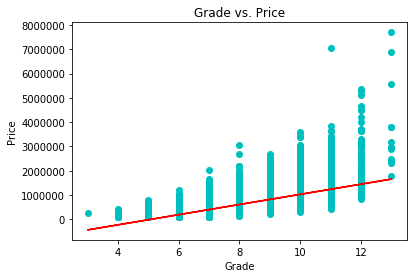

In [217]:
#Regression Line Grade vs. Price

y = df_lowp[['price']]
x =df_lowp.grade

Y = y.to_numpy().reshape(-1, 1) #Convert the dataframes to numpy arrays and reshape
X = x.to_numpy().reshape(-1, 1)


linreg.fit(X, Y)  # perform linear regression
Y_pred = linreg.predict(X)  # make predictions


plt.title('Grade vs. Price')
plt.xlabel('Grade')
plt.ylabel('Price')
plt.scatter(X, Y, c='c')
plt.plot(X, Y_pred, label='Line of Best Fit', color='red') #Line of best fit

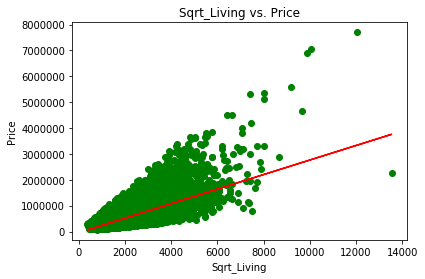

In [218]:
#Regression Line Sqft_Living vs. Price

y = df_lowp[['price']]
x =df_lowp.sqft_living

Y = y.to_numpy().reshape(-1, 1)
X = x.to_numpy().reshape(-1, 1)


linreg.fit(X, Y)  # perform linear regression
Y_pred = linreg.predict(X)  # make predictions


plt.title('Sqrt_Living vs. Price')
plt.xlabel('Sqrt_Living')
plt.ylabel('Price')
plt.scatter(X, Y, c ='g')
plt.plot(X, Y_pred, label='Line of Best Fit', color='red')

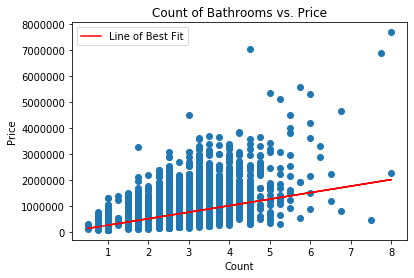

In [219]:
#Regression Line Yr_built vs. Price
y = df_lowp[['price']]
x =df_lowp.bathrooms

Y = y.to_numpy().reshape(-1, 1)
X = x.to_numpy().reshape(-1, 1)


linreg.fit(X, Y)  # perform linear regression
Y_pred = linreg.predict(X)  # make predictions

plt.title('Count of Bathrooms vs. Price')
plt.xlabel('Count')
plt.ylabel('Price')
plt.scatter(X, Y)
plt.plot(X, Y_pred, label='Line of Best Fit', color='red')
plt.legend()
plt.show()


### Plot the Visualizations of the Top 3 Variables to Check the Regression Assumptions with Respect to the Error Terms

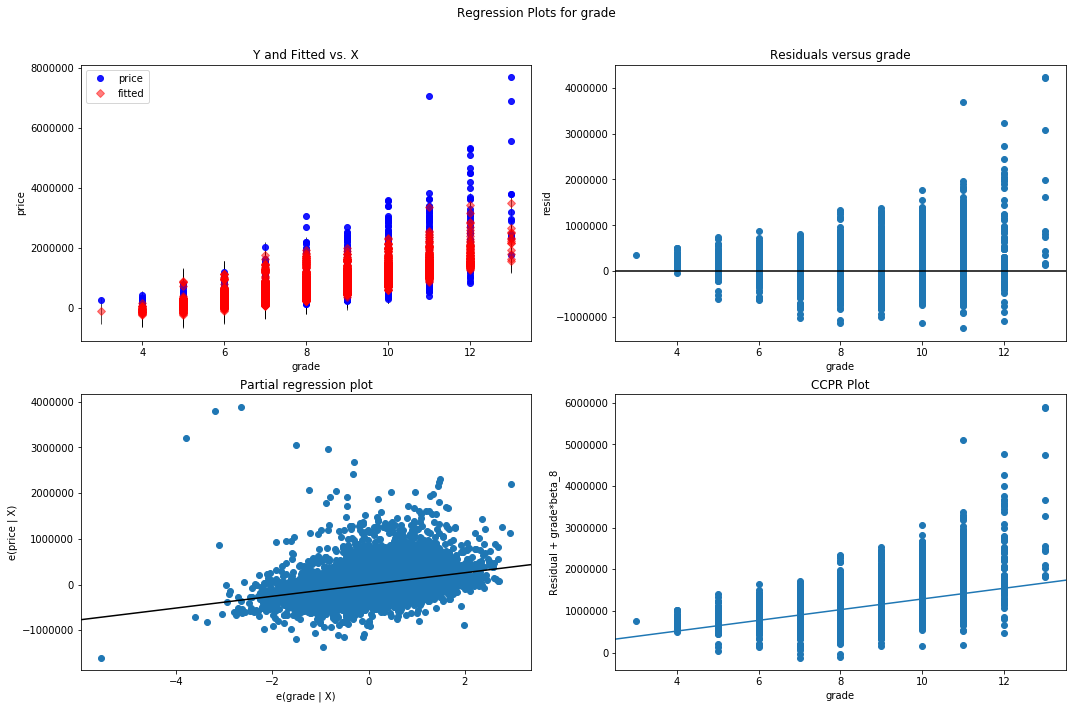

In [232]:
fig = plt.figure(figsize=(15,10))
fig = sm.graphics.plot_regress_exog(model, "grade", fig=fig)
plt.show()

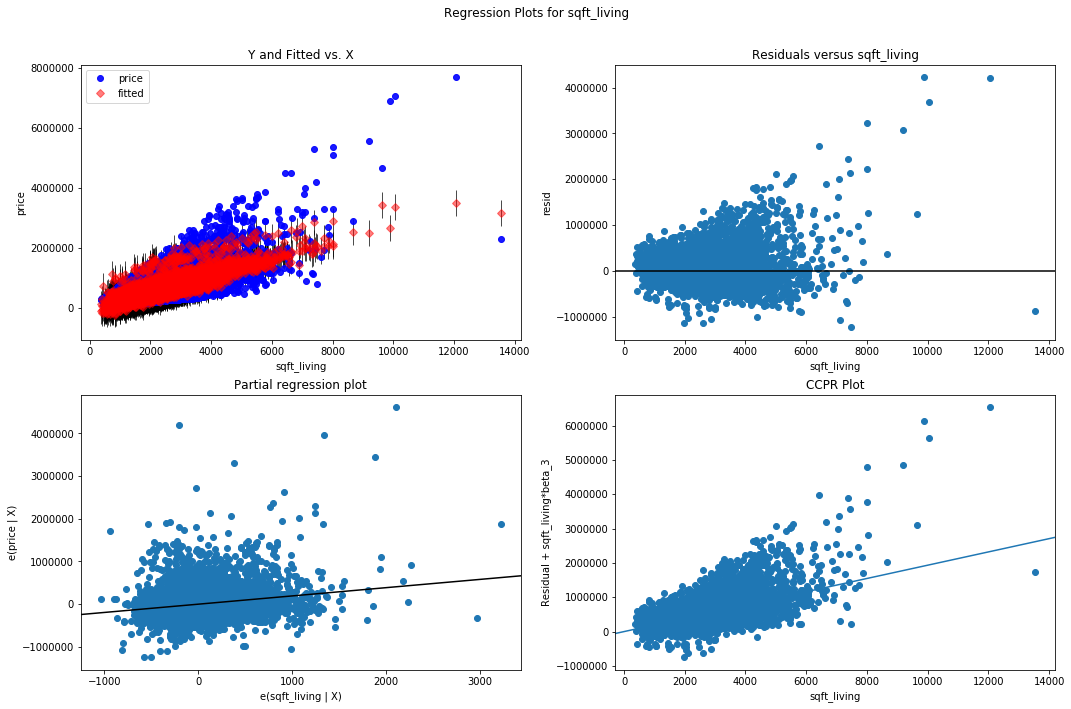

In [233]:
fig = plt.figure(figsize=(15,10))
fig = sm.graphics.plot_regress_exog(model, "sqft_living", fig=fig)
plt.show()

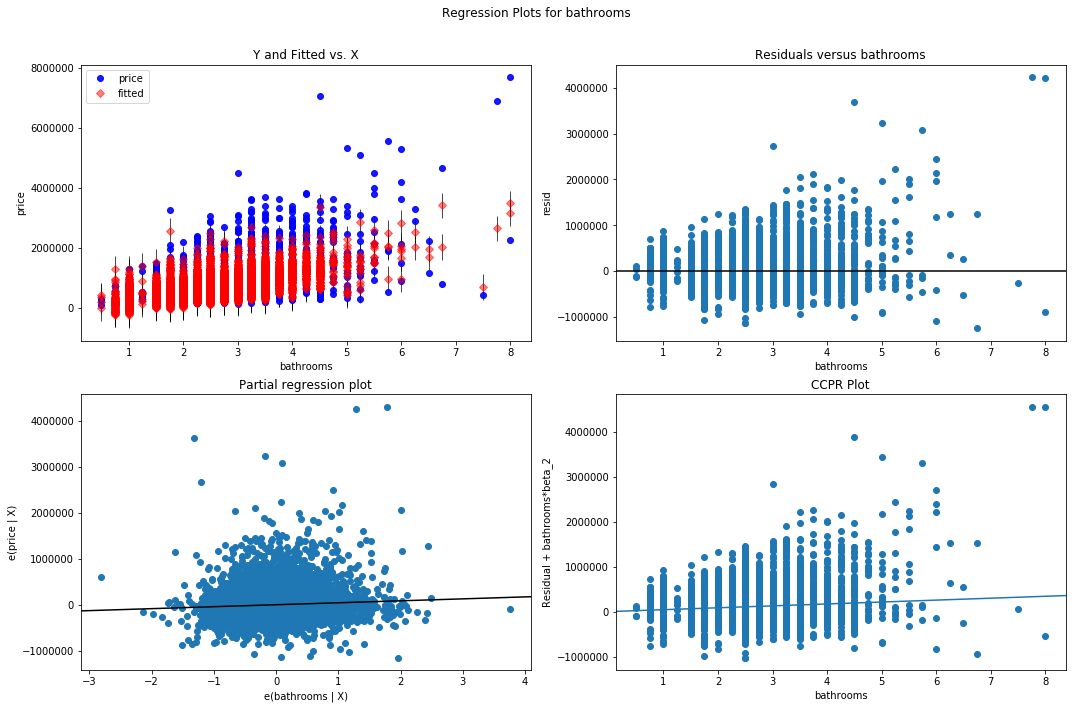

In [234]:
fig = plt.figure(figsize=(15,10))
fig = sm.graphics.plot_regress_exog(model, "bathrooms", fig=fig)
plt.show()

### Perform Recursive Feature Elimination to Determine the Most Important Features for a Model

In [223]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

predictors = df.drop('price', axis=1)
linreg = LinearRegression()
selector = RFE(linreg, n_features_to_select=5)
selector = selector.fit(predictors, df['price'])

In [224]:
selector.support_ #'True' indicates the selected features

array([False, False, False, False, False,  True, False,  True, False,
       False,  True, False, False,  True,  True, False, False])

In [225]:
selector.ranking_

array([ 8,  2, 10, 13,  7,  1,  6,  1, 12,  4,  1, 11,  9,  1,  1,  5,  3])

### Model Building: Trial 9 with Trimmed Outliers

In [226]:
from scipy import stats

# Identify the outliers 3 standard deviations away from mean in all columns
def remove_outliers(df, column_name, threshold=3):
    z_scores = stats.zscore(df[column_name])
    indices = np.abs(np.where(z_scores > threshold))
    return indices[0]
    
columns_to_check = ['price', 'bedrooms', 'sqft_lot', 'floors',
       'waterfront', 'condition', 'sqft_basement',
       'yr_built', 'zipcode','is_renovated',
       'perc']

all_indices = []
for column in columns_to_check:
    indices = remove_outliers(noncolin_df, column, threshold=3)
    all_indices.extend(indices)
all_indices = np.unique(all_indices)

# Remove outliers 3 standard deviations from mean in all columns
noncolin_df = noncolin_df.drop(index=all_indices)
noncolin_df.shape

(20068, 11)

       bedrooms  sqft_lot  floors  waterfront  condition  sqft_basement  \
0             3      5650     1.0         0.0          3            0.0   
2             2     10000     1.0         0.0          3            0.0   
3             4      5000     1.0         0.0          5            1.0   
4             3      8080     1.0         0.0          3            0.0   
5             4    101930     1.0         0.0          3            1.0   
...         ...       ...     ...         ...        ...            ...   
21591         3      1131     3.0         0.0          3            0.0   
21592         4      5813     2.0         0.0          3            0.0   
21593         2      1350     2.0         0.0          3            0.0   
21594         3      2388     2.0         0.0          3            0.0   
21595         2      1076     2.0         0.0          3            0.0   

       yr_built  zipcode  is_renovated      perc  
0          1955    98178           0.0  0.791150

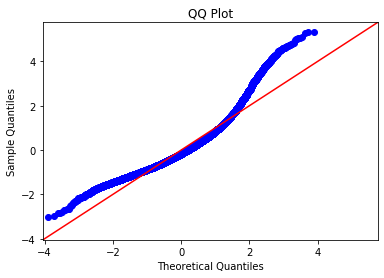

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.240
Method:                 Least Squares   F-statistic:                     794.0
Date:                Fri, 05 Jun 2020   Prob (F-statistic):               0.00
Time:                        08:42:33   Log-Likelihood:            -2.7541e+05
No. Observations:               20068   AIC:                         5.508e+05
Df Residuals:                   20059   BIC:                         5.509e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      2.308e+07   3.31e+06      6.964      0.000    1.66e+07    2.96e+07
bedrooms       7.094e+04   1936.845     36.628      0.000    6.71e+04    7.47e+04
sqft_lot          3.4875      0.136     25.596      0.000       3.220       3.755
floors         1.708e+05   3720.759     45.916      0.000    1.64e+05    1.78e+05
waterfront      1.61e-06   2.31e-07      6.964      0.000    1.16e-06    2.06e-06
condition      2.788e+04   2644.309     10.545      0.000    2.27e+04    3.31e+04
sqft_basement  1.094e+05   3523.613     31.058      0.000    1.03e+05    1.16e+05
yr_built      -1209.2005     72.707    -16.631      0.000   -1351.712   -1066.689
zipcode        -210.3867     33.187     -6.340      0.000    -275.435    -145.338
is_renovated           0          0        nan        nan           0           0
perc          -2.823e+05   1.93e+04    -14.606      0.000    -3.2e+05   -2.44e+05
==============================================================================
Omnibus:                     4661.314   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11617.248
Skew:                           1.277   Prob(JB):                         0.00
Kurtosis:                       5.715   Cond. No.                          inf
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [227]:

a = 'price'
b = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'zipcode', 'month_sold',
       'yr_sold', 'age', '%yard', 'is_renovated']

fullRegressionAnalysis(a=a, b=b, df=noncolin_df)

## Conclusion

The final model can predict housing sale prices at a rate of 65%. This is due, largely, to missing and incomplete data, outlier data. There are also other factors that are not apart of the dataset that strongly impact housing sale prices such as the types of renovations made, what structural improvements make up the "grade" and "condition" criteria. With this information, my team and I can build more robust models and accurate prediction models.